In [1]:
import pandas as pd
import numpy as np
import json

# plotting
import matplotlib.pyplot as plt

#opening data
import os
import pathlib
import warnings

#used for plots
from mplsoccer import Pitch
from scipy.stats import binned_statistic_2d

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

# Opening data

In [2]:
notebook_dir = pathlib.Path().absolute()
events_path = os.path.join(notebook_dir.parent, "wyscout-data", "events", "events_England.json")

with open(events_path) as f:
    events = json.load(f)

df = pd.DataFrame(events)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 643150 entries, 0 to 643149
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       643150 non-null  int64  
 1   subEventName  643150 non-null  object 
 2   tags          643150 non-null  object 
 3   playerId      643150 non-null  int64  
 4   positions     643150 non-null  object 
 5   matchId       643150 non-null  int64  
 6   eventName     643150 non-null  object 
 7   teamId        643150 non-null  int64  
 8   matchPeriod   643150 non-null  object 
 9   eventSec      643150 non-null  float64
 10  subEventId    643150 non-null  object 
 11  id            643150 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 58.9+ MB


# Actions moving the ball

- Filter out actions that move the ball
- Remove passes that went out of play
- Create new columns for coordinates
- Plot locations in a histogram
- Store number of actions in each bin in *move_count* array

In [9]:
# Add new column for next event (used to filter out passes that went out of play)
next_event = df.shift(-1, fill_value=0)
df["nextEvent"] = next_event["subEventName"]
df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis=1)

# Get actions that move the ball
move_df = df[df["subEventName"].isin(["Simple pass", "High pass", "Head pass", "Smart pass", "Cross"])]

# Filter out actions that end in out of play
passes_to_delete = move_df[move_df["kickedOut"] == 1]
move_df = move_df.drop(passes_to_delete.index)
passes_to_delete.head()


,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,kickedOut
108,8,High pass,[{'id': 1802}],7868,"[{'y': 14, 'x': 40}, {'y': 100, 'x': 67}]",2499719,Pass,1609,1H,364.985980,83,177959270,Ball out of the field,1
143,8,High pass,"[{'id': 901}, {'id': 1802}]",14853,"[{'y': 4, 'x': 63}, {'y': 96, 'x': 100}]",2499719,Pass,1631,1H,498.389197,83,177959354,Ball out of the field,1
189,8,High pass,[{'id': 1802}],370224,"[{'y': 76, 'x': 53}, {'y': 87, 'x': 95}]",2499719,Pass,1609,1H,656.021673,83,177959368,Ball out of the field,1
217,8,Simple pass,[{'id': 1802}],25413,"[{'y': 38, 'x': 30}, {'y': 0, 'x': 28}]",2499719,Pass,1609,1H,752.105957,85,177959390,Ball out of the field,1
533,8,Simple pass,[{'id': 1802}],3319,"[{'y': 57, 'x': 31}, {'y': 0, 'x': 30}]",2499719,Pass,1609,1H,1650.546495,85,177959757,Ball out of the field,1


In [20]:
# Create new columns for coordinates
move_df["x"] = move_df["positions"].apply(lambda cell: (cell[0]["x"]) * 105/100)
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df["positions"].apply(lambda cell: (100 - cell[0]["y"]) * 68/100)
move_df["endX"] = move_df["positions"].apply(lambda cell: (cell[1]["x"]) * 105/100)
move_df["endY"] = move_df["positions"].apply(lambda cell: (100 - cell[1]["y"]) * 68/100)

# Remove actions that end in the corners of the pitch (right corners on horizontal pitch)
move_df = move_df[((move_df["endX"] != 0) & (move_df["endY"] != 68)) & ((move_df["endX"] != 105) & (move_df["endY"] != 0))]
move_df.shape

(307333, 20)

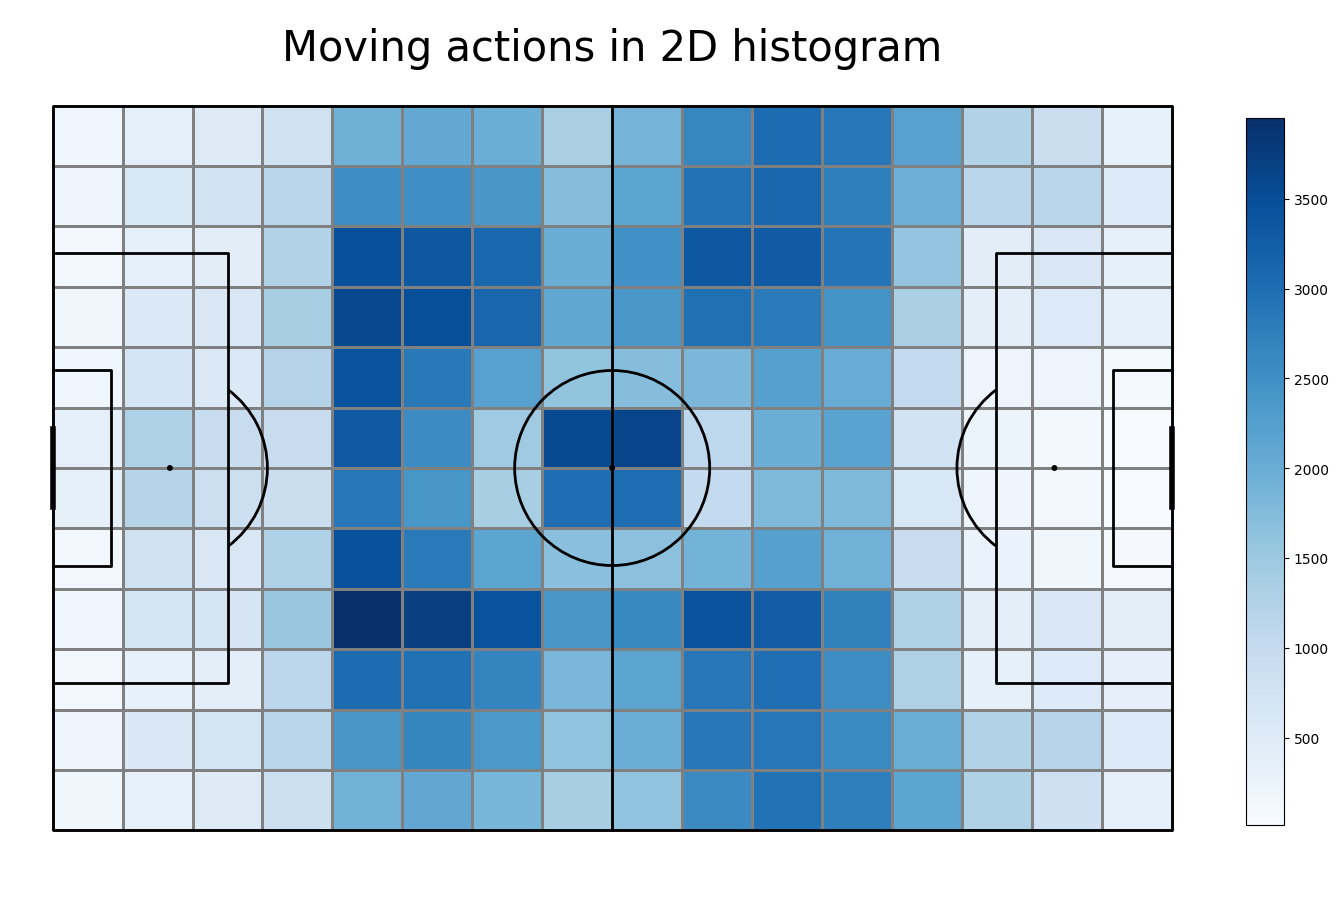

In [21]:
# Init pitch
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder=2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

# Create bins
move = pitch.bin_statistic(move_df["x"], move_df["y"], statistic='count', bins=(16, 12), normalize=False)

# Get the move count array
move_count = move["statistic"]

# Plot bins in heatmap
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

# Legend
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Moving actions in 2D histogram', fontsize = 30)
plt.show()